In [12]:
%matplotlib inline
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [13]:
import numpy as np
from pathlib import Path
import os
import torch.optim as optim
import random

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

# our models of choice
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [14]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.55
transformers version : 2.2.2


### Transformers model Zoo
Create a dictionary of parameters required for creating different model classes

In [17]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

### Make model selection here

In [23]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [24]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [25]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

### Use the same randomization seed so as to compare different models more easily

In [21]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

### Data pre-processing
The important thing here is that `FastAI` uses **processors** to perform repeatetive tasks when creating `DataBunch`. A set of default **processors** are performed for fastai.textlearners. For example:
  

In [ ]:
# FastAI use various processors to perform repeatative tasks in data pipeline

def _get_processor(tokenizer:Tokenizer=None, vocab:Vocab=None, chunksize:int=10000, max_vocab:int=60000,
                   min_freq:int=2, mark_fields:bool=False, include_bos:bool=True, include_eos:bool=False):
    return [TokenizeProcessor(tokenizer=tokenizer, chunksize=chunksize, 
                              mark_fields=mark_fields, include_bos=include_bos, include_eos=include_eos),
            NumericalizeProcessor(vocab=vocab, max_vocab=max_vocab, min_freq=min_freq)]

class NumericalizeProcessor(PreProcessor):
    "`PreProcessor` that numericalizes the tokens in `ds`."
    def __init__(self, ds:ItemList=None, vocab:Vocab=None, max_vocab:int=60000, min_freq:int=3):
        vocab = ifnone(vocab, ds.vocab if ds is not None else None)
        self.vocab,self.max_vocab,self.min_freq = vocab,max_vocab,min_freq

    def process_one(self,item): return np.array(self.vocab.numericalize(item), dtype=np.int64)
    def process(self, ds):
        if self.vocab is None: self.vocab = Vocab.create(ds.items, self.max_vocab, self.min_freq)
        ds.vocab = self.vocab
        super().process(ds)

#### We need to overwrite the "tokenizer" and "numericalizer" in order to tailor the databunch creating process to the `Transformers`
Later when creating `DataBunch`, we are going to pass in our customized processors

## Tokenizer
Step 1: create a new tokenizer that inherit from `fastai`'s `BaseTokenizer`

In [26]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

Step 2: Get the 'pre-trained tokenizer' from `transformer` library.(this is used for initialization of the class we created above)

In [28]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)

Step 3: Create the actual **tokenizer** for our transformer of choice and put a `FastAI` wrapper on

In [29]:
Tokenizer

fastai.text.transform.Tokenizer

In [30]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In this implementation, be carefull about 3 things :

1. As we are not using RNN, we have to limit the sequence length to the model input size.
2. Most of the models require special tokens placed at the beginning and end of the sequences.
3. Some models like RoBERTa require a space to start the input string. For those models, the encoding methods should be called with add_prefix_space set to True.

Below, you can find the resume of each pre-process requirement for the 5 model types used in this tutorial. You can also find this information on the [HuggingFace documentation](https://huggingface.co/transformers/) in each model section.<br>
`bert:       [CLS] + tokens + [SEP] + padding`<br>
`roberta:    [CLS] + prefix_space + tokens + [SEP] + padding`<br>
`distilbert: [CLS] + tokens + [SEP] + padding`<br>
`xlm:        [CLS] + tokens + [SEP] + padding`<br>
`xlnet:      padding + [CLS] + tokens + [SEP]`

It is worth noting that we don't add padding in this part of the implementation.  As we will see later, fastai manage it automatically during the creation of the `DataBunch`.

## Numericalizer
In `fastai` library, `NumericalizeProcessor` object takes as `bocab` argument a `Vocab` object. Here we will create a new class `TransformerVocab` that inherits from `Vocab` and overwrite `numericalize` and `textify` functions.

In [31]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

### Customize numericalize processor
Notice taht we need to pass the `include_bs=False` and `include_eos=False` options. This is because `fastiai` adds its own special tokens by default which interferes with the `[CLS]` and `[SEP]` tokens that are required for RoBERTa

In [32]:
NumericalizeProcessor

fastai.text.data.NumericalizeProcessor

In [33]:
# use RoBERTa tokenizer to initialize the `TransformersVocab
transformer_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

# create a customized numericalizor using vocab just created
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)


## Put together our customized processor

In [34]:
TokenizeProcessor

fastai.text.data.TokenizeProcessor

In [35]:
# wrapper function over the tokenizer we created above
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


In [36]:
# finally put the two processors in a list for later use
transformer_processor = [tokenize_processor, numericalize_processor]

# Create DataBunch
For the DataBunch creation, you have to pay attention to set the processor argument to our new custom processor `transformer_processor` and manage correctly the padding.

As mentioned in the [HuggingFace documentation](https://huggingface.co/transformers/), BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [37]:
# If we are using Google XLNet
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

## Prepare the full IMDB dataset and inspect the files under that path

In [38]:
path = untar_data(URLs.IMDB)
path

PosixPath('/home/projectx/.fastai/data/imdb')

In [39]:
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [40]:
(path/'train').ls()

[PosixPath('/home/projectx/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/pos'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/projectx/.fastai/data/imdb/train/neg')]

## Data for LM training
The reviews are in a training and test folder. In addition, we have a 'unsup' folder that contains many reviews are 
are **not labelled**.<br>
In the second training phase of ULMFiT, as mentioned in the [README](https://github.com/Sylar257/Sentiment-Analysis/blob/master/README.md)
, we will be fine-tuning the language model to the domain-specific corpus.<br>
Thus, training could take advantage of using 'train', 'test', and 'unsup' folder.

### Create a DataBunch for language model
What does that mean?<br>
Basically we are creating a databunch for our learner later in a way that we ignore the true label('negataive' or  'positive'). Hence, the task we constructed is as simple as to just predict the **next word** without worrying about what the sentiment.

In [41]:
# we can play around with the batch_size as long as the GPU can take it
bs = 48
data_lm = (TextList.from_folder(path, processor=transformer_processor)                         # specify the path
           .filter_by_folder(include=['train','test','unsup'])# exclude other folders
           .split_by_rand_pct(0.1, seed=seed)                 # randomly split and keep 10% for validation set
           .label_for_lm()                                    # label as to "predict the next word token"
           .databunch(bs=bs))                                 # convert to databunch for the learner later

In [45]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(90000, 10000)

In [43]:
# take a peek at a small sample of data
data_lm.show_batch()

idx,text
0,/ 55 21 _ 8 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 8 180 _ 9 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 59 17 _ 8 . txt </s> <s> Ġ/ home / project x /. fast ai /
1,/ test / pos / 26 44 _ 10 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 55 15 _ 10 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 782 _ 9 . txt </s> <s> Ġ/ home / project x /.
2,im db / test / pos / 14 18 _ 10 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 59 19 _ 8 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 92 11 _ 9 . txt </s> <s> Ġ/ home /
3,_ 9 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 11 103 _ 10 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 8 644 _ 10 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im
4,im db / test / pos / 9 808 _ 10 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 12 395 _ 10 . txt </s> <s> Ġ/ home / project x /. fast ai / data / im db / test / pos / 14 07 _ 7 . txt </s> <s> Ġ/ home /


In [8]:
# this is a comparison with databunch processed by FastAI defaul processors
data_lm.show_batch()

idx,text
0,"for romantic comedies ( i do n't know why ) . xxmaj the trailers i saw were not appealing , the cast did not look that interesting and i had no idea what the plot would be about . xxmaj in the end i found it to be an interesting meditation on relationships and family . i thoroughly enjoyed myself and must admit that i thought that this film was"
1,"use of the word . xxmaj yes , it 's gritty , sexy , down home truth , bizarre and in - your - face real . xxmaj is n't that the best reason to see a movie ? xxmaj those that get my meaning wo n't stay away from seeing this another week . xxbos xxmaj this brings back so many childhood memories . ( i 'm not old"
2,"xxmaj now i 'm convinced more than ever , that my appraisal was correct after seeing a master film maker like xxmaj jean xxmaj renoir 's version of the same story . xxmaj he succeeded in getting great performances out of his entire cast , and the great xxmaj french actor , xxmaj jean xxmaj gabin was in rare form . xxmaj the dance sequence near the end was one"
3,"it 's difficult to talk to her ? \n \n xxmaj this film is not as fascinating as xxmaj cassavetes 's xxmaj faces or xxmaj opening xxmaj night , but it has that riveting quality that xxmaj cassavetes always fought so hard to render , which is an unbridled depiction of people underneath the ego that hides behind itself in nearly all other films . xxmaj gena xxmaj rowlands"
4,'s xxmaj westerns are my favorites and this slides easily to a satisfaction . a xxmaj western of this kind is in the pages of the past and perhaps never to be made much again . xxmaj one to enjoy . xxmaj gave it a 7 rating . xxmaj likely 6.8 worthy but films like these become more precious over time . \n \n xxmaj for film - noir


In [46]:
# Let's save our databunch so that we don't have to re-run this the next time
data_lm.save('lm_databunch_RoBERTa')

In [48]:
# Note that the databunch is saved under 'path' rather than the current directory
path.ls()

[PosixPath('/home/projectx/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/projectx/.fastai/data/imdb/models'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch_RoBERTa'),
 PosixPath('/home/projectx/.fastai/data/imdb/test'),
 PosixPath('/home/projectx/.fastai/data/imdb/imdb_textlist_classifier'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/projectx/.fastai/data/imdb/train'),
 PosixPath('/home/projectx/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/projectx/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/projectx/.fastai/data/imdb/README'),
 PosixPath('/home/projectx/.fastai/data/imdb/unsup')]

In [ ]:
# load the databunch we created ealier
bs = 48
data_lm = load_data(path, 'lm_databunch_RoBERTa', bs=bs)

In [50]:
# a sanity check for <s>; </s>; <pad>
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


In [51]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_lm.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([48, 70])
tensor([[23687,    73,   757,  ...,     2,     0,  1589],
        [16963,  1439,    73,  ...,   466,     4, 46795],
        [28258,  1178, 11665,  ...,  2983,  1215,   406],
        ...,
        [   73, 28258,  1178,  ...,  1215,   288,     4],
        [ 8361,    73, 28258,  ..., 26300,  1215,   288],
        [11665, 16963,  1439,  ..., 46795,     2,     0]])


## Customize model
As mentioned [here](https://github.com/huggingface/transformers#models-always-output-tuples), every model's forward method always outputs a tuple with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits.  One way to access them is to create a custom model.

In [52]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

Download the pretrained weights for RoBERTa

In [76]:
transformer_tokenizer.vocab_size

50265

In [77]:
# this is the configuration of language model
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = transformer_tokenizer.vocab_size
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 50265,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [78]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [79]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

In [85]:
learn_lm = language_model_learner(data_lm, 
                   custom_transformer_model, 
                   opt_func = CustomAdamW)
learn_lm.callbacks.append(ShowGraph(learn_lm))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

KeyError: CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (1): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (2): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (3): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (4): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (5): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (6): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (7): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (8): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (9): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (10): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
          (11): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
                (dropout): Dropout(p=0.1)
              )
            )
            (intermediate): BertIntermediate(
              (dense): Linear(in_features=768, out_features=3072, bias=True)
            )
            (output): BertOutput(
              (dense): Linear(in_features=3072, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1)
            )
          )
        )
      )
      (pooler): BertPooler(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (activation): Tanh()
      )
    )
    (classifier): RobertaClassificationHead(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1)
      (out_proj): Linear(in_features=768, out_features=50265, bias=True)
    )
  )
)

In [83]:
learn_lm.model

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out

In [84]:
learn_lm.lr_find()
learn_lm.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: Expected input batch_size (48) to match target batch_size (3360).

Now, we will be creating our leaner with the base architecture being `AWD_LSTM`

In [63]:
# the drop_mult decide the percentage of dropout to use in relation to the combination used in the original paper
learn_lm_AWD = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

AssertionError: Padding_idx must be within num_embeddings

### Vocabulary
As we can see below, when we create `TextDataBunch` a  `vocab` property is created simultaneously. <br>
It's worth pointing out that, for `index-to-strings` and `strings-to-index` we have a different length. This is primarily because that there are some words that appear infrequently so that it's not effcient for them to occupy one token. What we do is to map all of these low frequency words to `xxunk`. We can ditermine the `min_freq` in the following function

In [14]:
vocab = data_lm.vocab

In [15]:
vocab.stoi["stingray"]

35055

In [16]:
vocab.stoi["happy"]

675

In [17]:
vocab.itos[vocab.stoi['mamamia']]

'xxunk'

In [18]:
len(learn_lm.model)

2

In [52]:
# ourmodel has two parts, the AWD_LSTM base architecture and the linear classifier
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

#### Comments on `drop_mult`
From the original [AWD_LSTM paper](https://arxiv.org/pdf/1708.02182.pdf) the authors applied several effective techniques.<br>

**DropConnect** was implemented in the architecture in that weight matrices are *dropped* before the *forward* and *backward* pass.<br>

**Variational dropout**. In standard dropout, a new binary dropout mask is sampled each and every time the dropout function is called. **Variational dropout** only samples a *dropout mask* upon the first call and then will repeatedly use that *locked dropout* mask for all repeated connections within the forward and backward pass.<br>

The values used for *dropout on the word vectors*, the *output between LSTM layers*, the *output of the final LSTM layer*, and *embedding dropout* were (0.4, 0.3, 0.4, 0.1), respectively.

### Encoder
Encoder is the first layer of the AWD_LSTM, which is also known as the `embedding layer`

In [20]:
enc = learn_lm.model[0].encoder
enc.weight.size()  # 400 is the embedding size

torch.Size([60000, 400])

In [21]:
# recall that 60000 is the vocab size of our language model vocabulary
len(data_lm.vocab.itos)

60000

## Before training
Let's try to use this model(only pre-trained with wiki-text) to generate fake movie reviews

In [22]:
TEXT = 'The color of the sky is'
N_WORDS = 40
N_SENTENCES = 2

In [23]:
# Note that the 'temperature' denote the randomness we adopt when pick next words
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is often changed from black to blue , to give it a more light color . The color is derived from the colours of one of the sky planets and the blue sky . The bird 's colour is

The color of the sky is a reference to the thin red hair of the Earth . The physical presence of the moon in the sky and the dark sky in the dark , and the so - called Earth - like sky


In [24]:
# If 'temperature'  set to super low, there will be almost no randomness
N_SENTENCES = 3
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.05) for _ in range(N_SENTENCES)))

The color of the sky is a matter of controversy , as the Sun is not a white sky , but a white sky . The Sun is a dark , dark , dark , dark , dark , dark , dark ,

The color of the sky is a matter of debate , and the International Union of Red and White Stars ( NAACP ) has been the most popular group of the American public . The American

The color of the sky is a matter of controversy , as the Sun has been described as a " dark , dark , dark , dark , dark , dark , dark , dark , dark , dark , dark , dark , dark


In [25]:
# Change TEXT
TEXT = 'I hate this movie so much'
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hate this movie so much it does not last for a single , less weekly , or just a few more pages of a book , so it can be seen as Lily Allen 's second novel The Spirit of

I hate this movie so much that i think i would be thinking about it . The greatest reason why i wanted to make a movie about a movie was that you would not let it go , because it was not a chance to

I hate this movie so much that i can ' t do that . It could make you want to see what is right . But i don ' t hope to see what the right thing can do , and as many as


In [35]:
doc(LanguageLearner.predict)

### Fine-tuning a language model
We can use the `data_lm` object we created earlier to fine-tune a pretrained language model. 
Here we will be using a pre-trained `AWD-LSTM` architecture theat is available in FastAI.

In [53]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:
# The plot function attached to lr_finder
# Note that we get a smoothened version where `skip_start` and `skip_end` decide howmuch to trim-off from start or end

def plot(self, skip_start:int=10, skip_end:int=5, suggestion:bool=False, return_fig:bool=None,
             **kwargs)->Optional[plt.Figure]:
        "Plot learning rate and losses, trimmed between `skip_start` and `skip_end`. Optionally plot and return min gradient"
        lrs = self._split_list(self.lrs, skip_start, skip_end)
        losses = self._split_list(self.losses, skip_start, skip_end)
        losses = [x.item() for x in losses]
        if 'k' in kwargs: losses = self.smoothen_by_spline(lrs, losses, **kwargs)
        fig, ax = plt.subplots(1,1)
        ax.plot(lrs, losses)
        ax.set_ylabel("Loss")
        ax.set_xlabel("Learning Rate")
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        if suggestion:
            try: mg = (np.gradient(np.array(losses))).argmin()
            except:
                print("Failed to compute the gradients, there might not be enough points.")
                return
            print(f"Min numerical gradient: {lrs[mg]:.2E}")
            ax.plot(lrs[mg],losses[mg],markersize=10,marker='o',color='red')
            self.min_grad_lr = lrs[mg]
            ml = np.argmin(losses)
            print(f"Min loss divided by 10: {lrs[ml]/10:.2E}")
        if ifnone(return_fig, defaults.return_fig): return fig
        if not IN_NOTEBOOK: plot_sixel(fig)

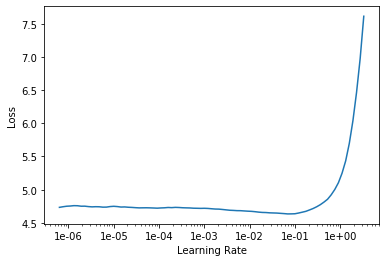

In [54]:
learn_lm.recorder.plot()

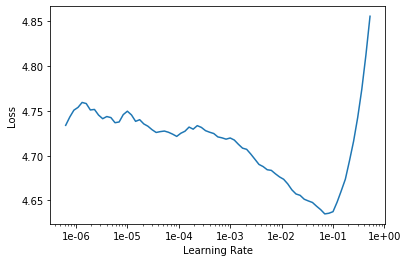

In [55]:
# Trim the last 15 datapoints so that we have clearer view
learn_lm.recorder.plot(skip_end=15)

We want to select a `learning_rate` where the slope is steep and not going upwards.<br>
`lr=5e-3` seems to be a sensible choice

In [56]:
lr=5e-3
learn_lm.to_fp16()
learn_lm.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.167812,4.067869,0.291104,21:03
1,4.200355,4.070581,0.290157,21:04
2,4.133083,4.029402,0.293869,21:05
3,4.056716,3.989157,0.298245,21:05
4,3.998321,3.979450,0.299676,21:05


In [57]:
learn_lm.save('fit_freezed_5_epochs')

In [ ]:
learn_lm.load('fit_freezed_5_epochs')

In [58]:
# now we see that the aacuracy is positively improving
# we can unfreeze and train further
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10,lr/5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.806393,3.795424,0.318980,23:47
1,3.786836,3.768348,0.324682,23:48
2,3.763445,3.743657,0.328573,23:45
3,3.717152,3.711501,0.332588,23:46
4,3.619674,3.682857,0.335828,23:45
5,3.578209,3.660896,0.338813,23:45
6,3.528988,3.642530,0.341307,23:45
7,3.461757,3.632708,0.342691,23:45
8,3.392899,3.631087,0.343060,24:03
9,3.364762,3.633080,0.342879,24:07


In [59]:
learn_lm.save('fine_tuned_lm')
learn_lm.save_encoder('fine_tuned_lm_enc')

In [60]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [62]:
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it was true to life , a true story about a lame social worker who gets his to check out his own fantasy club . He always thinks he is an artist , but he ca n't see how

i liked this movie because of the heroic acts Richard Gere said to Richard Gere . i liked the way the film was supposed to be , and i was surprised how little was done in the moment . It


In [63]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was really bad . The acting was poor , and the story had no excitement . And the " plot " , was non - existent , and had

This movie was clearly done by people who did n't know what the TV series was . The whole story line was n't very interesting . The acting was quite


### Now the language model is much more "*IMDB like*"

In [64]:
bs = 48
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs, num_workers=1))

In [65]:
data_clas.save('imdb_textlist_classifier')

In [67]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos * * * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . * * * \n \n xxmaj before i begin , i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that",neg
"xxbos xxmaj okay , so i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games",neg
"xxbos xxmaj in xxup nyc , seaman xxmaj michael o'hara ( xxmaj orson xxmaj welles ) rescues xxmaj elsa xxmaj bannister ( xxmaj rita xxmaj hayworth ) from a mugging & rape as she takes a horse & carriage through xxmaj central xxmaj park -and lives to regret it . xxmaj xxunk - haired xxmaj hayworth 's a platinum blonde in this one ; as dazzling as fresh - fallen",pos


## Creating ultimate-model: IMDB review classifier
Three simple steps to create our review classifier after fine tuning our language model with IMDb dataset:
    1. Create a `text_classifier_learner` with `AWD_LSTM` as base archietecture(note that we can use any model here as base architecture, but it has to be the same with the one we just trained as language model. So if we want a transformer here, we would be training a transformer language model in the previous section)
    2. Load the `fine-tuned-language-model-encoder`. We have save both the encoder as well as the entire model. We would only be needing the encoder's weights here as we will be replacing the head as a freshly initialize classifier and train it later.
    3. Freeze the body(base architecture) of our model, and train just the head first. We can make use of our usual trategy be looking for the optimal learning rate.

In [69]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn_clas.load_encoder('fine_tuned_lm_enc')
learn_clas.freeze()

In [71]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


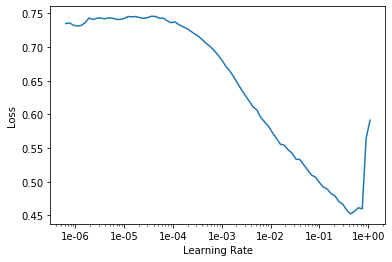

In [72]:
learn_clas.recorder.plot()

### Here we will be turning our model to mixed-precision in order to speed up the training

In [74]:
learn_clas.to_fp16();

In [75]:
learn_clas.fit_one_cycle(10, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.242503,0.202670,0.921240,02:05
1,0.245878,0.232431,0.908080,02:07
2,0.243902,0.219563,0.914240,02:25
3,0.242020,0.179243,0.933080,02:17
4,0.230897,0.175639,0.935120,02:25
5,0.225465,0.178500,0.934600,02:13
6,0.224750,0.173133,0.935280,02:26
7,0.203338,0.175705,0.934680,02:16
8,0.194384,0.172137,0.936440,02:18
9,0.212245,0.184981,0.935640,02:16


In [76]:
learn_clas.save('learn_clas_freezed')

### Gradual unfreezing during fine-tuning our classifier
Fine-tuning the target classifier is the most critical part of the *transfer learning method*. Overly aggressive fine-tuning will cause catastrophic forgetting, eliminating the benefit of the information captured through language modeling; too cautious fine-tuning will lead to slow convergence (and resultant overfiting). Besides discriminative fine-tuning and triangular learning rates, **gradual unfreezing** is proposed.

Jeremy et al. found that for RNN-base NLP models, by gradually unfreeze the layers from head to bottom we minimize the forgetting incurred for each *transfer learning* thus maximize our effort done in the previous training section.

We first unfreeze the **last layer** and fine-tune all un-frozen layers for one epoch.

Then unfreeze the **next lower frozen layer** and repeat.

Until all unfrozen layers converges.

In [78]:
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.222187,0.180545,0.931840,02:30
1,0.199225,0.155029,0.943760,02:45
2,0.155391,0.151604,0.945680,02:31
3,0.093648,0.169559,0.943680,02:39
4,0.058335,0.191606,0.941960,02:37


In [79]:
learn_clas.save('learn_clas_unfreed_second')

In [81]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(5, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.064002,0.204184,0.940280,03:32
1,0.090188,0.196067,0.936440,03:21
2,0.051633,0.197808,0.939760,03:08
3,0.025068,0.227497,0.944320,03:35
4,0.011097,0.242228,0.944400,03:08


In [82]:
learn_clas.save('learn_clas_unfreezed_third')

In [87]:
learn_clas.load('learn_clas_unfreezed_third');

In [88]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(15, slice(4e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.017045,0.236845,0.943680,04:11
1,0.017342,0.244636,0.944000,04:31
2,0.010597,0.256718,0.944560,04:23
3,0.010705,0.262101,0.944880,04:18
4,0.013174,0.271987,0.943320,04:18
5,0.007575,0.276141,0.943960,04:12
6,0.005873,0.276535,0.944960,03:44
7,0.010663,0.292337,0.945400,04:18
8,0.007185,0.300464,0.945200,04:26
9,0.009154,0.294201,0.944960,04:31


In [85]:
learn_clas.save('learn_clas_unfreezed_final')

The state-of-the-art result for IMDB sentimant classification result in 2017 is **94.1%**
What we can do even better, is to build a **reversed model** as well and training a meta-learner on top of that.
For this technique, we will be experimenting with more detail in my [sentiment analysis with non-English language]() repo.